In [1]:
from pathlib import Path

Before running this notebook the files have to be downloaded. See [01a Download from Scihub.ipynb](01a Download from Scihub.ipynb) for further information.

The calculation in this notebook depends on three parameters:

- `product_path` is the path to a previously downloaded product
- `index_to_calculate` is one of the supported indices; these are 'ndvi'
  - ndvi -- normalized difference in vegetation
  - nbr -- normalized burn ratio
  - bsi -- bare soil index
- `fill_value`, the value which is used to represent invalid pixels to handle division by zero.

Change the values below and select _Kernel → Restart and Run All Cells_ to re-evaluate all cells in this notebook.
The path of the output file will be printed below the last cell.

In [2]:
downloads = ['input/forest_fires/S2A_MSIL2A_20190613T101031_N0212_R022_T33UUT_20190614T125329.zip',
 'input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip',
 'input/forest_fires/S2A_MSIL2A_20190626T102031_N0212_R065_T33UUT_20190626T125319.zip']

In [3]:
product_path = Path(downloads[1])
index_to_calculate = 'nbr'

## Preview of product

Uncomment the following lines to plot a true-color image of the downloaded data:

In [4]:
#from sentinel_helpers import scihub_band_paths
#import rasterio.plot as rplot
#
#tci = scihub_band_paths(product_path, 'TCI', '60m')[0]
#with r.open(tci) as src:
#    rplot.show(src)

## Define Formulas

We define the formulas as data so we can substitute the bands with actual values later on and execute the operations when needed.
We use a lisp-like language with prefix notation for this.

### Operators

Index calculations take the following form:

$$
NDVI = (B08 - B04) / (B08 + B04)
$$

This means they do pixel-wise operations on bands which we can express using numpy ndarrays.
The ndarrays have overloaded operators, so for two arrays `array_a` and `array_b` with an identical shape `array_a + array_b` adds each cell in `array_a` with the corresponding cell in `array_b`.
The exact behavior of numpy arrays in this regard is called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

We define the basic arithmetic operations `+`, `-`, `*` and `/` as functions taking variadic arguments:

In [5]:
from functools import reduce

def add(nums):
    return reduce(lambda a, b: a + b, nums)

def sub(nums):
    return reduce(lambda a, b: a - b, nums)

def div(nums):
    return reduce(lambda a, b: a / b, nums)

def mul(nums):
    return reduce(lambda a, b: a * b, nums)

### Indices

This section contains the formula definitions for a selection of indices.
These definitions are not exhaustive - there are many spectral indices which are not implemented in this notebook - however the general shape of this formula allows for enough flexibility to implement other indices as well.

The formulas are defined in a lisp-like prefix notation: `(add, 1, 2, 3)` translates to `1 + 2 + 3`.
Each element in a formula can be either a function, a string or a tuple.
A string represents a band number, a function represents an arithmetic operation and a tuple allows us to express nested formulas.

We first define some spectral indices using these basic elements:

In [6]:
indices = {
    # normalized difference in vegetation
    'ndvi': (div, (sub, 'B08', 'B04'), (add, 'B08', 'B04')),
    # normalized burn ratio
    'nbr': (div, (sub, 'B08', 'B12'), (add, 'B08', 'B12')),
    # bare soil index
    'bsi': (div, (sub, (add, 'B11', 'B04'), (add, 'B08', 'B02')),
                 (add, (add, 'B11', 'B04'), (add, 'B08', 'B02')))
}

… and verify that the `index_to_calculate` above has a matching implementation:

In [7]:
supported_indices = ', '.join(indices.keys())
assert index_to_calculate in supported_indices, f'Only the following indices are supported: {supported_indices}'

### Resolving the Formulas

We define a function that returns all of the bands referenced in a formula.
This is necessary when resolving these references to data sets.

In [8]:
def get_bands(formula):
    bands = set()
    for element in formula:
        if type(element) == tuple:
            # recur for subformulas
            for band in get_bands(element):
                bands.add(band)
        elif type(element) == str:
            bands.add(element)
    return bands

The resolving process needs a `band_map` in the form of `band_num` → `numpy.array`:

In [9]:
def evaluate_formula(band_map, formula):
    op = formula[0]
    args = []
    for element in formula[1:]:
        if type(element) == tuple:
            # recur on sub-formula
            args.append(evaluate_formula(band_map, element))
        elif type(element) == str:
            # substitute band number
            args.append(band_map[element])
        else:
            # just append the number
            args.append(element)
    return op(args)

We also define a function that makes working with the prefix notation a bit easier to avoid errors that can occur when translating the formulas:

In [10]:
def prefix_to_infix_str(formula):
    '''
    Returns a human-readable string of the above data-based notation. Useful
    for debugging.
    '''
    result = ['(']
    
    # operation
    op = formula[0]
    if op == add:
        sym = ' + '
    elif op == sub:
        sym = ' - '
    elif op == div:
        sym = ' / '
    elif op == mul:
        sym = ' * '
        
    operands = formula[1:]
    for idx, operand in enumerate(operands, start=1):
        if type(operand) == tuple:
            result.append(prefix_to_infix_str(operand))
        else:
            result.append(str(operand))
        if idx < len(operands):
            result.append(sym)
        
    result.append(')')
    return ''.join(result)

#### Small test

In [11]:
formula = (add, *range(5), (mul, *range(1, 4))) # == (add, 0, 1, 2, 3, 4, (mul, 1, 2, 3))

In [12]:
prefix_to_infix_str(formula)

'(0 + 1 + 2 + 3 + 4 + (1 * 2 * 3))'

In [13]:
evaluate_formula({}, formula)

16

## Extraction of relevant band file paths

We start by extracting the information which bands are referenced by the index formula given by `index_to_calculate`:

In [14]:
bands = get_bands(indices[index_to_calculate])
bands = list(bands)
bands

['B12', 'B08']

## Resampling

Some bands are not available in all resolutions.

The band `B08` is available only at 10m and the band `B12` only at 20m:

In [15]:
from sentinel_helpers import scihub_band_paths
band_paths = list(sorted(scihub_band_paths(product_path, bands)))
band_paths

['zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R10m/T33UUT_20190603T101031_B08_10m.jp2',
 'zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R20m/T33UUT_20190603T101031_B12_20m.jp2',
 'zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R60m/T33UUT_20190603T101031_B12_60m.jp2']

This can be solved by upsampling the lower bands to the highest available resolution.
First we discard duplicate bands which are already available in higher resolution:

In [16]:
highest_resolution_band_paths = []
covered_bands = set()
for band in band_paths:
    band_num = band.split('_')[-2]
    if band_num in covered_bands:
        continue
    else:
        highest_resolution_band_paths.append(band)
        covered_bands.add(band_num)
highest_resolution_band_paths

['zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R10m/T33UUT_20190603T101031_B08_10m.jp2',
 'zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R20m/T33UUT_20190603T101031_B12_20m.jp2']

In [17]:
def resolution(band_path):
    '''
    Return the resolution encoded in a raster file's path.
    '''
    return int(band_path.split('_')[-1].split('.')[0].replace('m', ''))

The target resolution is given by the raster with the highest resolution. 

In [18]:
target_resolution = list(sorted(resolution(band) for band in highest_resolution_band_paths))[0]
target_resolution

10

## Generate the raster cloud mask

Spectral indices can get distorted by highly reflective clouds.
These clouds need to be excluded.

In order to construct a cloud mask that we can operate on, we need to know the transformation needed from the coordinates given by the raster's coordinate reference system to the pixel coordinates of the highest resolution raster.

These are encoded as metadata in the raster file:

In [19]:
from sentinel_helpers import scihub_cloud_mask
import rasterio as r
import matplotlib.pyplot as pplt

highres_raster_path = [band_path for band_path in highest_resolution_band_paths if resolution(band_path) == target_resolution][0]
highres_raster_path

'zip+file://input/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip!/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.SAFE/GRANULE/L2A_T33UUT_A020611_20190603T101041/IMG_DATA/R10m/T33UUT_20190603T101031_B08_10m.jp2'

In [20]:
with r.open(highres_raster_path) as src:
    target_transform = src.transform
    target_shape = src.shape

target_shape, target_transform

((10980, 10980),
 Affine(10.0, 0.0, 300000.0,
        0.0, -10.0, 5800020.0))

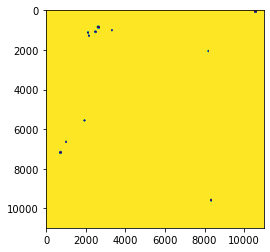

In [21]:
# pixels with clouds are True, pixels without are False
raster_cloud_mask = scihub_cloud_mask(product_path,
                                      rasterize=True,
                                      target_shape=target_shape,
                                      target_transform=target_transform)

pplt.imshow(raster_cloud_mask)

## Calculate the index

In [22]:
import numpy as np
import numpy.ma as ma

from rasterio.enums import Resampling
import rasterio.plot as rplt

from sentinel_helpers import RasterReaderList, scihub_cloud_mask, scihub_normalize_range
from tqdm.notebook import tqdm

from tempfile import NamedTemporaryFile

out_dir = Path('output/spectral_indices/')
out_dir.mkdir(exist_ok=True, parents=True)

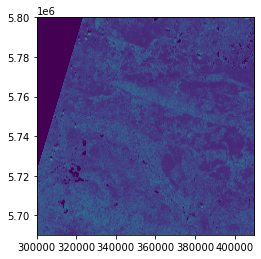

In [23]:
with r.open(highest_resolution_band_paths[0]) as src:
    data = src.read(1)
    rplt.show(src)

In [24]:
(data & raster_cloud_mask).mean()

0.007747626915637307

In [ ]:
%%time

with RasterReaderList(highest_resolution_band_paths) as readers:
    # build the band_map as described above and scale up where needed
    band_map = {}
    for reader in tqdm(readers, desc='Resampling datasets'):
        band_num = reader.name.split('_')[-2]
        data_resolution = resolution(reader.name)
        scale_factor = int(data_resolution / target_resolution)
        out_shape = (
            int(reader.height * scale_factor),
            int(reader.width * scale_factor)
        )
        
        band_map[band_num] = (np.clip(
            # we read only the first band to obtain a two-dimensional ndarray
            reader.read(1, out_shape=out_shape, resampling=Resampling.bilinear, masked=True),
        0, 10000) / 10000).astype('float32')
        
        if scale_factor == 1:
            out_name = Path(reader.name).name.replace(band_num, index_to_calculate.upper())
            out_name = out_name.replace('.jp2', '.tif')
            out_path = out_dir / out_name
            out_meta = reader.meta.copy()
    
    # ignore numpy division errors (i.e. divide by 0) in this context;
    # divide by zero results in `nan`, which we fill with zeros. clouds are
    # masked using the raster_cloud_mask created above
    with np.errstate(divide='ignore', invalid='ignore'):
        index = evaluate_formula(band_map, indices[index_to_calculate])
        # we need to invert the cloud mask (`~`) because we want to hide those pixels that are cloudy
        tile_mask = ~raster_cloud_mask | index.mask
        index = ma.masked_array(index, tile_mask)
    
    out_meta.update({
        'count': 1,
        'driver': 'GTiff',
        'dtype': 'float32'
    })
    
    with r.open(out_path, 'w+', **out_meta) as dst:
        dst.write(index.data, 1)
        # note that the mask we write has an inverted interpretation of 
        # True / False due to the `.msk` file format
        dst.write_mask(~index.mask)
        print(f'Wrote result to {out_path}')

In [ ]:
# to debug the cloud / tile mask, uncomment these lines
# pplt.imshow(tile_mask)

In [ ]:
with r.open(out_path, 'r') as src:
    rplt.show(src)

In [ ]:
# writing the mask explicitly works:
# dst.write(index.data, 1)
# dst.write_mask(~index.mask)